In [34]:
import re
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import pickle
from sklearn.neighbors import KNeighborsClassifier

# Get data

In [35]:
dataset_filename = "../../linguistic_model/data/synthetic_clan_merge_c4.csv"
df = pd.read_csv(dataset_filename, encoding='utf8', index_col=False)

In [36]:
df.head()

,modified,label
0,"there are no details, and everything is seen f...",0
1,bridging and.,1
2,mencia and his legions of fans are like that c...,0
3,we collect interned and for you.,1
4,has your.,1


In [37]:
# no null values 
df.isnull().sum()

modified    0
label       0
dtype: int64

In [38]:
sentences = df["modified"]

<Axes: xlabel='label', ylabel='count'>

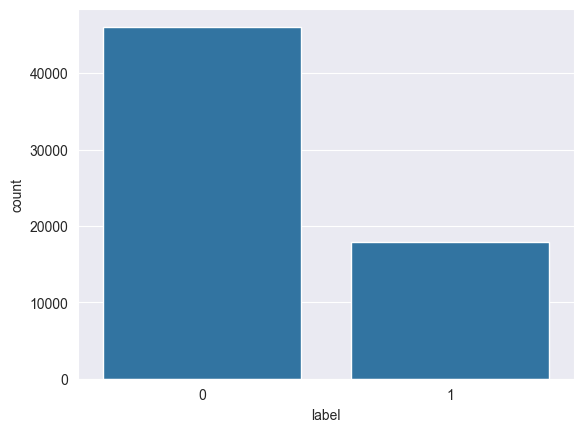

In [39]:
# A bit unbalanced
sns.countplot(x="label",data=df)

In [40]:
input_df = df

In [41]:
input_df

,modified,label
0,"there are no details, and everything is seen f...",0
1,bridging and.,1
2,mencia and his legions of fans are like that c...,0
3,we collect interned and for you.,1
4,has your.,1
...,...,...
63957,"maybe not like the beatles, but something appr...",0
63958,"when the book scarlett came out, i read it in ...",0
63959,"avoid this film at all costs, and if your moth...",0
63960,some this her.,1


# Encoding # 1

In [42]:
import multiprocessing
from gensim.models import Word2Vec

In [43]:
cores = multiprocessing.cpu_count()
cores

16

In [44]:
words_in_sentences=[]
for i in input_df["modified"]:
    words_in_sentences.append(re.findall(r"[\w']+|[.,!?;]", i.lower()))
words_in_sentences[20]

['maybe',
 'this',
 'is',
 'the',
 'movie',
 'number',
 'one',
 'million',
 'that',
 'talks',
 'about',
 'nazis',
 '.']

In [45]:
input_df.iloc[20]

modified    maybe this is the movie number one million tha...
label                                                       0
Name: 20, dtype: object

In [46]:
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     vector_size = 300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-10)

In [47]:
w2v_model.build_vocab(words_in_sentences, progress_per=10000)

In [48]:
w2v_model.train(words_in_sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(12064415, 30561630)

In [49]:
w2v_model.save("word2vec_rf_reverse.model")

In [50]:
w2v_model = Word2Vec.load("word2vec_rf_reverse.model")

In [51]:
vocab=list(w2v_model.wv.key_to_index.keys())
print(len(vocab))

38250


In [52]:
def avg_w2vec(sentences, labels):
    """
    Average Word2Vec approach for creating a vector for a given sentence from the word embeddings of each words of the sentence.
    """

    transformed=[]
    lab = []
    for sentence, label in zip(sentences,labels):
        count=0
        vector=np.zeros(300)
        for word in sentence.split():
            if word in vocab:
                vector+=w2v_model.wv.get_vector(word)
                count+=1
        if count!=0:
            vector/=count
            transformed.append(vector)
            lab.append(label)
    return np.array(transformed), np.array(lab)

In [53]:
transformed_text, labels1= avg_w2vec(input_df["modified"], input_df["label"])

# Model fitting

In [54]:
# train test split
x_train,x_test, y_train, y_test = train_test_split(transformed_text, labels1, stratify=labels1, test_size=0.20, random_state=42)

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100)


In [56]:
forest = forest.fit(x_train, y_train)

In [57]:
rfPickle = open('rf_reverse_pickle', 'wb')
pickle.dump(forest, rfPickle)
rfPickle.close()

# Testing plots

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [59]:
loaded_model = pickle.load(open('rf_reverse_pickle', 'rb'))

In [60]:
loaded_model

RandomForestClassifier()

In [61]:
result = loaded_model.predict(x_test)

In [62]:
len(x_test)

11568

In [63]:
len(y_test)

11568

In [64]:
print(accuracy_score(y_test, result))

0.9382780082987552


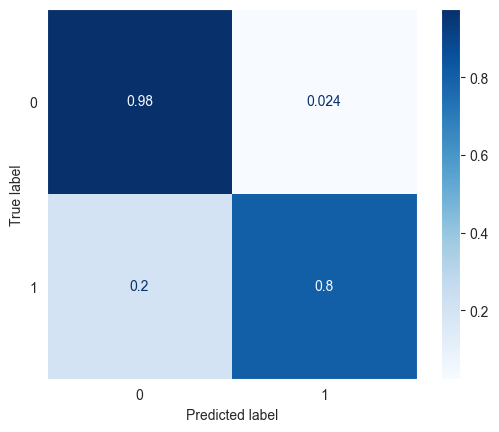

In [65]:
cm = confusion_matrix(y_test, result, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_estimator(loaded_model, x_test,y_test, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [66]:
print(tn, fn, tp, fp)

0.9756798585009949 0.1958762886597938 0.8041237113402062 0.024320141499005084


In [67]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

0.9706435850593181
0.8041237113402062
0.8795716752161259
